In [2]:
#1차 데이터 전처리 특성중요도 0.01미만 54개 제거
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)

# 특성 중요도 확인
importances = rf_model.feature_importances_
features = data_input.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 중요도가 낮은 특성 제거 (중요도 0.01 미만인 특성 제거)
important_features = feature_importances[feature_importances['Importance'] > 0.01]['Feature']
data_input_reduced = data_input[important_features]

# 중요한 특성만 포함한 데이터프레임에 타겟 변수 'Bankrupt?' 컬럼 추가
data_reduced_with_target = data_input_reduced.copy()
data_reduced_with_target['Bankrupt?'] = data_target


data_reduced_with_target.to_csv('./train_data_reduced.csv', index=False)



In [3]:
# 제거할 특성 불러오기
low_importance_features = pd.read_csv('./low_importance_features.csv')['Feature'].tolist()

# 새로운 데이터 불러오기
test_data = pd.read_csv('./test_data.csv')

# 제거할 특성을 데이터에서 제거
test_data_reduced = test_data.drop(columns=low_importance_features)

# 중요한 특성만 포함된 새로운 데이터 저장
file_path_test_reduced = './test_data_reduced.csv'
test_data_reduced.to_csv(file_path_test_reduced, index=False)

file_path_test_reduced

'./test_data_reduced.csv'

In [4]:
test_data = pd.read_csv('./test_data_reduced.csv')
ntest_input = test_data.drop(columns=['Bankrupt?'])
ntest_input_reduced = ntest_input[important_features]
ntest_target = test_data['Bankrupt?']

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('./train_data_reduced.csv')

# 데이터 분리 (중요도가 낮은 특성 제거 후)
train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
    data_input_reduced, data_target, random_state=42)

# 랜덤 포레스트 모델 재학습
rf_model_reduced = RandomForestClassifier(random_state=42)
rf_model_reduced.fit(train_input_reduced, train_target_reduced)


# 3. 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(train_input_reduced, train_target_reduced)

best_rf_model = grid_search.best_estimator_

print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 재학습
best_rf_model.fit(train_input_reduced, train_target_reduced)

# 예측 (하이퍼파라미터 튜닝 후)
train_predictions_tuned = best_rf_model.predict(train_input_reduced)
test_predictions_tuned = best_rf_model.predict(test_input_reduced)
ntest_predictions_tuned = best_rf_model.predict(ntest_input_reduced)

# 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
ntest_accuracy_tuned = accuracy_score(ntest_target, ntest_predictions_tuned)

print(f"훈련 세트 정확도 (하이퍼파라미터 튜닝 후): {train_accuracy_tuned}")
print(f"테스트 세트 정확도 (하이퍼파라미터 튜닝 후): {test_accuracy_tuned}")
print(f"ntest 세트 정확도 (하이퍼파라미터 튜닝 후): {ntest_accuracy_tuned}")

# 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
cv_accuracy_tuned = np.mean(cv_scores_tuned)

# 교차 검증 평가 - MSE, MAE (하이퍼파라미터 튜닝 후)
cv_predictions_tuned = cross_val_predict(best_rf_model, data_input_reduced, data_target, cv=5)

print("교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후): ", cv_accuracy_tuned)


최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}
훈련 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9777560498655585
테스트 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9714076246334311
ntest 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9860703812316716
교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후):  0.965352887259395


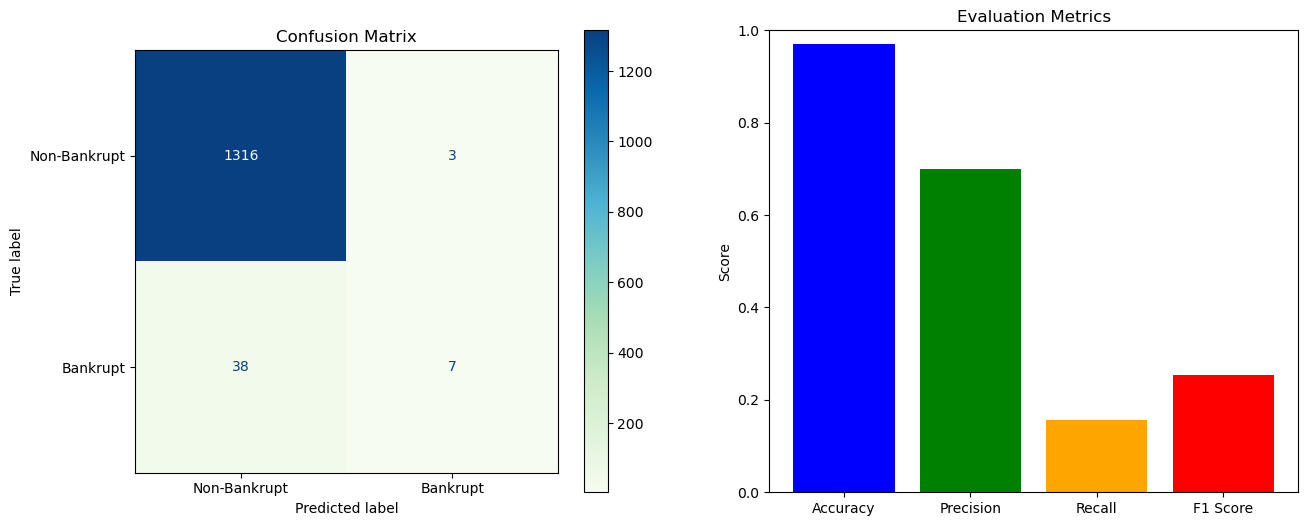

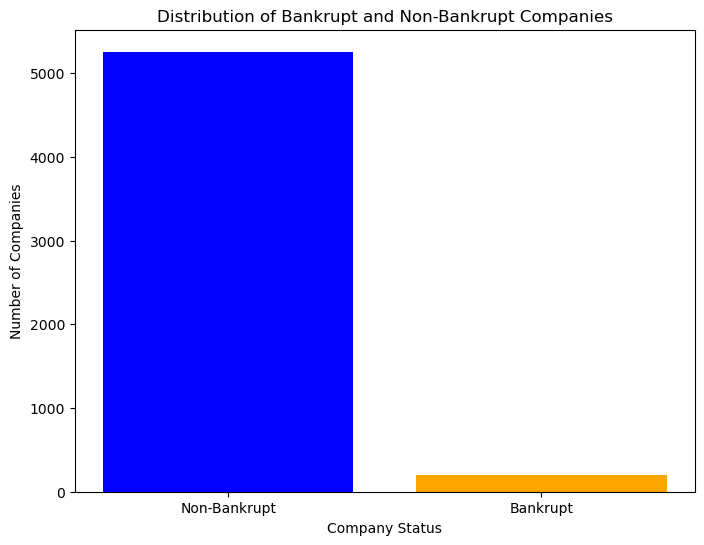

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습 및 예측
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap = 'GnBu')
axes[0].set_title('Confusion Matrix')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
axes[1].bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics')
axes[1].set_ylabel('Score')

plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['blue', 'orange'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status')
plt.ylabel('Number of Companies')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies')
plt.show()


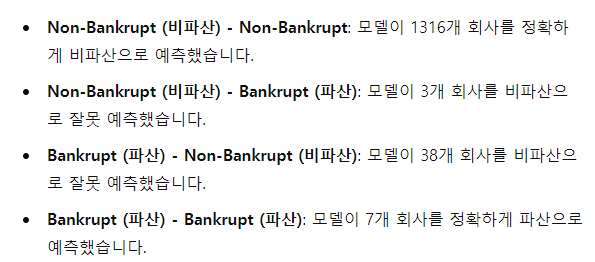

- Accuracy (정확도): 전체 예측 중에서 올바르게 예측한 비율입니다. 이 경우 약 97%로 매우 높습니다.
- Precision (정밀도): 모델이 파산으로 예측한 회사 중 실제로 파산인 회사의 비율입니다. 약 0.7로 비교적 낮습니다.
- Recall (재현율): 실제 파산인 회사 중 모델이 정확히 파산으로 예측한 비율입니다. 약 0.16으로 매우 낮습니다.
- F1 Score: 정밀도와 재현율의 조화 평균입니다. 약 0.26으로 낮습니다.
- 정확도는 매우 높지만, 데이터 불균형 문제로 인해 정밀도, 재현율, F1 점수가 낮습니다. 이는 모델이 비파산 회사를 예측하는 데 매우 강하지만, 파산 회사를 잘 예측하지 못한다는 것을 의미합니다.

- 혼동 행렬은 모델이 비파산 회사를 잘 예측하지만, 파산 회사를 잘 예측하지 못한다는 것을 보여줍니다.
- 평가 지표는 높은 정확도에도 불구하고, 정밀도, 재현율, F1 점수가 낮아 모델의 예측 성능이 파산 예측에 약하다는 것을 시사합니다.
- 데이터 분포는 데이터셋이 매우 불균형하다는 것을 시각적으로 보여줍니다.
- 결론적으로, 높은 정확도는 데이터 불균형 문제를 반영하지 못하며, 모델의 성능을 평가하는 데 있어 정밀도, 재현율, F1 점수와 같은 다른 평가 지표를 고려해야 합니다. 이를 통해 모델이 실제로 중요한 파산 예측에서 얼마나 잘 수행되는지를 평가할 수 있습니다.

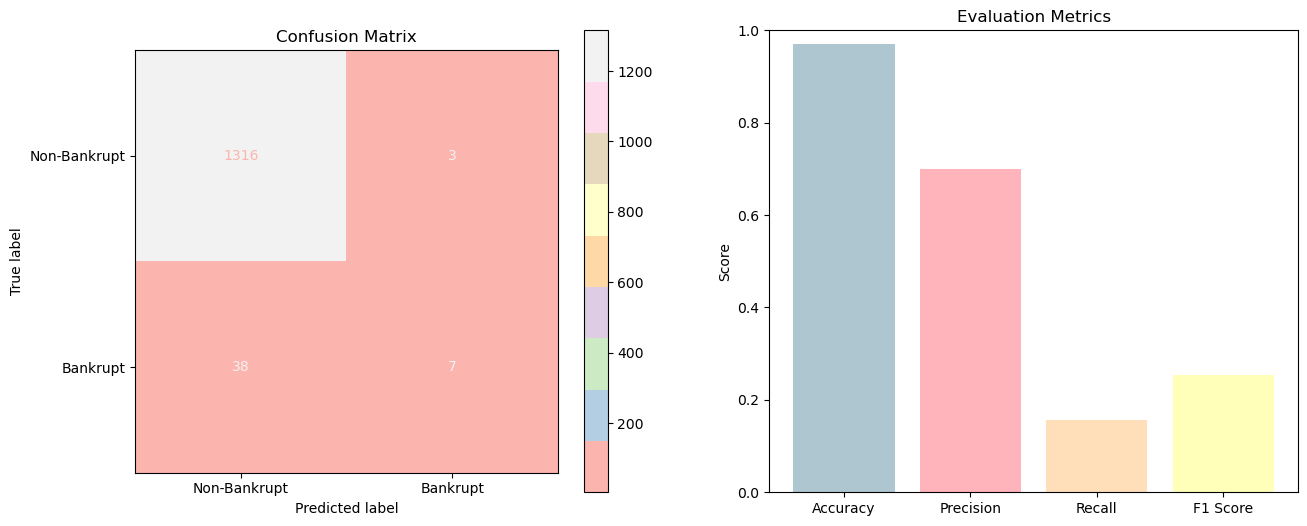

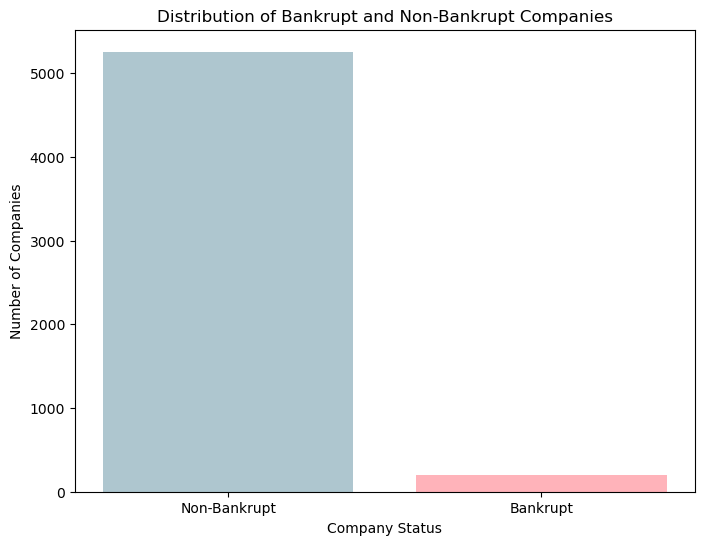

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습 및 예측
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 파스텔 색상 팔레트
pastel_colors = ['#aec6cf', '#ffb3ba', '#ffdfba', '#ffffba']

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('white')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Pastel1')
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
axes[1].bar(metrics, scores, color=pastel_colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics')
axes[1].set_ylabel('Score')

plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#aec6cf', '#ffb3ba'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status')
plt.ylabel('Number of Companies')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies')
plt.show()


In [13]:
import seaborn as sns
correlations=data.corr()['Bankrupt?'].abs().sort_values()
num_col_to_drop=int(0.7 * len(data.columns))
cols_drop=correlations.iloc[:num_col_to_drop].index
df_dropped= data.drop(cols_drop, axis=1)

<Axes: >

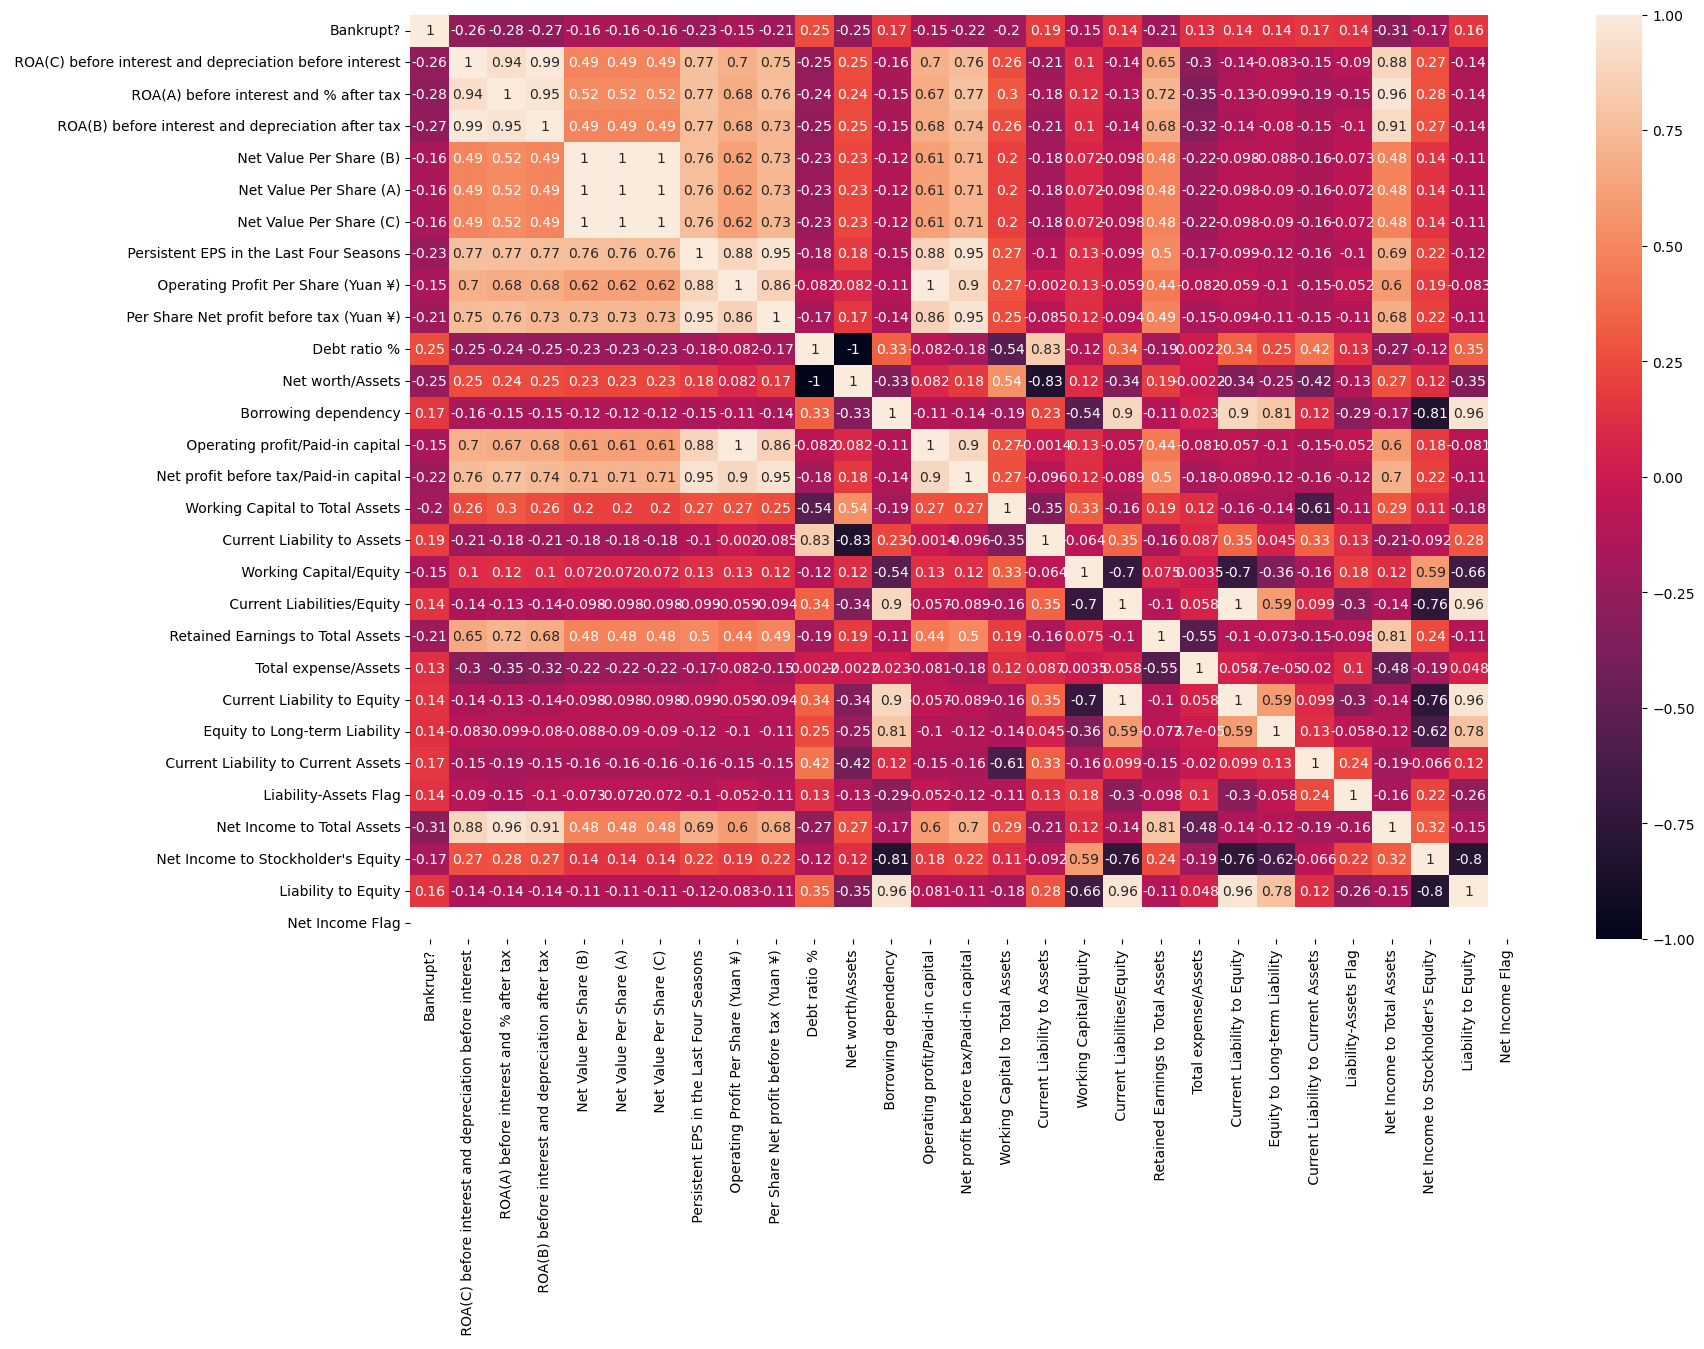

In [14]:
plt.figure(figsize=(18,12))
sns.heatmap(df_dropped.corr(), annot=True)

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 데이터 불러오기
data = pd.read_csv('./train_data_reduced.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(800, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

# 특성과 타겟 변수 분리 (중요도가 낮은 특성 제거 후)
data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
    data_input_reduced, data_target, random_state=42)

# 랜덤 포레스트 모델 재학습
rf_model_reduced = RandomForestClassifier(random_state=42)
rf_model_reduced.fit(train_input_reduced, train_target_reduced)

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(train_input_reduced, train_target_reduced)

best_rf_model = grid_search.best_estimator_

print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 재학습
best_rf_model.fit(train_input_reduced, train_target_reduced)

# 예측 (하이퍼파라미터 튜닝 후)
train_predictions_tuned = best_rf_model.predict(train_input_reduced)
test_predictions_tuned = best_rf_model.predict(test_input_reduced)

# 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)

print(f"훈련 세트 정확도 (하이퍼파라미터 튜닝 후): {train_accuracy_tuned}")
print(f"테스트 세트 정확도 (하이퍼파라미터 튜닝 후): {test_accuracy_tuned}")

# 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
cv_accuracy_tuned = np.mean(cv_scores_tuned)

print("교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후): ", cv_accuracy_tuned)

# 교차 검증 평가 - MSE, MAE (하이퍼파라미터 튜닝 후)
cv_predictions_tuned = cross_val_predict(best_rf_model, data_input_reduced, data_target, cv=5)
mse = mean_squared_error(data_target, cv_predictions_tuned)
mae = mean_absolute_error(data_target, cv_predictions_tuned)

print(f"교차 검증 MSE (하이퍼파라미터 튜닝 후): {mse}")
print(f"교차 검증 MAE (하이퍼파라미터 튜닝 후): {mae}")


최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 200}
훈련 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9371657754010695
테스트 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9
교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후):  0.8887688442211056
교차 검증 MSE (하이퍼파라미터 튜닝 후): 0.11122244488977956
교차 검증 MAE (하이퍼파라미터 튜닝 후): 0.11122244488977956


최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 100}
훈련 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9411764705882353
테스트 세트 정확도 (하이퍼파라미터 튜닝 후): 0.888
교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후):  0.8917638190954774
교차 검증 MSE (하이퍼파라미터 튜닝 후): 0.10821643286573146
교차 검증 MAE (하이퍼파라미터 튜닝 후): 0.10821643286573146


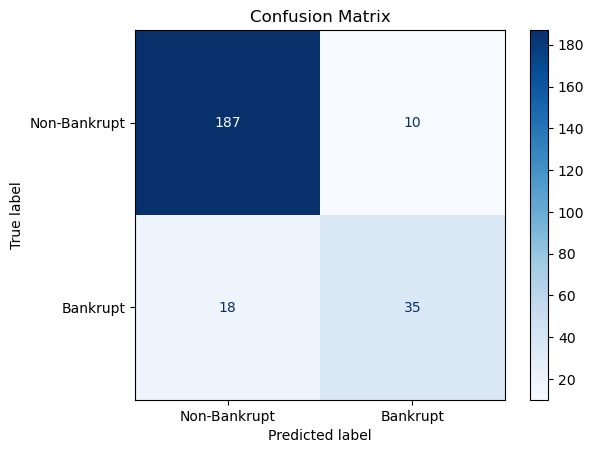

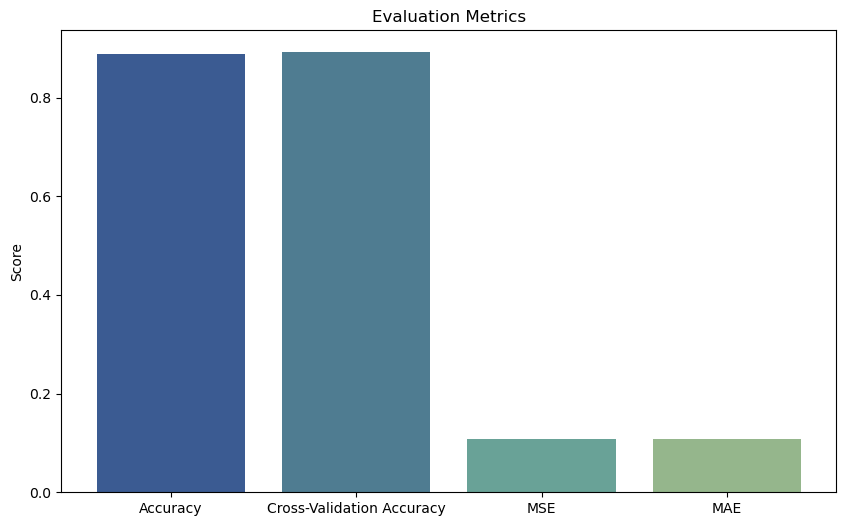

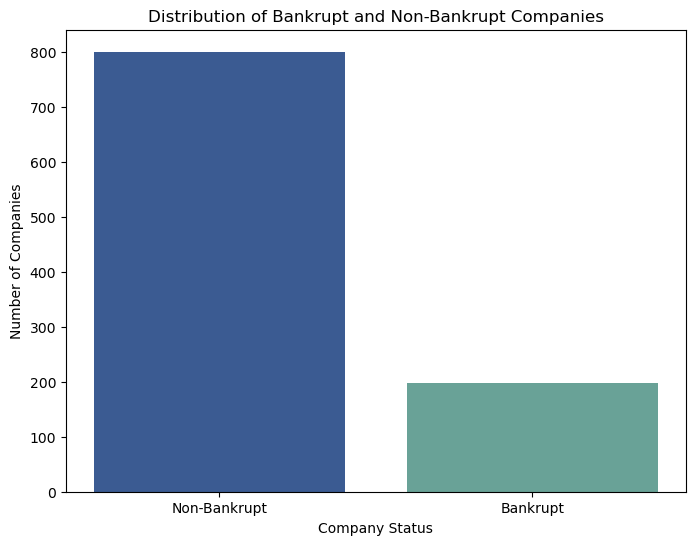

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('./train_data_reduced.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(800, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

# 특성과 타겟 변수 분리 (중요도가 낮은 특성 제거 후)
data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
    data_input_reduced, data_target, random_state=42)

# 랜덤 포레스트 모델 재학습
rf_model_reduced = RandomForestClassifier(random_state=42)
rf_model_reduced.fit(train_input_reduced, train_target_reduced)

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(train_input_reduced, train_target_reduced)

best_rf_model = grid_search.best_estimator_

print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 재학습
best_rf_model.fit(train_input_reduced, train_target_reduced)

# 예측 (하이퍼파라미터 튜닝 후)
train_predictions_tuned = best_rf_model.predict(train_input_reduced)
test_predictions_tuned = best_rf_model.predict(test_input_reduced)

# 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)

print(f"훈련 세트 정확도 (하이퍼파라미터 튜닝 후): {train_accuracy_tuned}")
print(f"테스트 세트 정확도 (하이퍼파라미터 튜닝 후): {test_accuracy_tuned}")

# 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
cv_accuracy_tuned = np.mean(cv_scores_tuned)

print("교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후): ", cv_accuracy_tuned)

# 교차 검증 평가 - MSE, MAE (하이퍼파라미터 튜닝 후)
cv_predictions_tuned = cross_val_predict(best_rf_model, data_input_reduced, data_target, cv=5)
mse = mean_squared_error(data_target, cv_predictions_tuned)
mae = mean_absolute_error(data_target, cv_predictions_tuned)

print(f"교차 검증 MSE (하이퍼파라미터 튜닝 후): {mse}")
print(f"교차 검증 MAE (하이퍼파라미터 튜닝 후): {mae}")

# 시각화
# 혼동 행렬 시각화
conf_matrix = confusion_matrix(test_target_reduced, test_predictions_tuned)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 평가 지표 시각화
metrics = ['Accuracy', 'Cross-Validation Accuracy', 'MSE', 'MAE']
scores = [test_accuracy_tuned, cv_accuracy_tuned, mse, mae]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=colors)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#3b5b92', '#69a297'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status')
plt.ylabel('Number of Companies')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies')
plt.show()


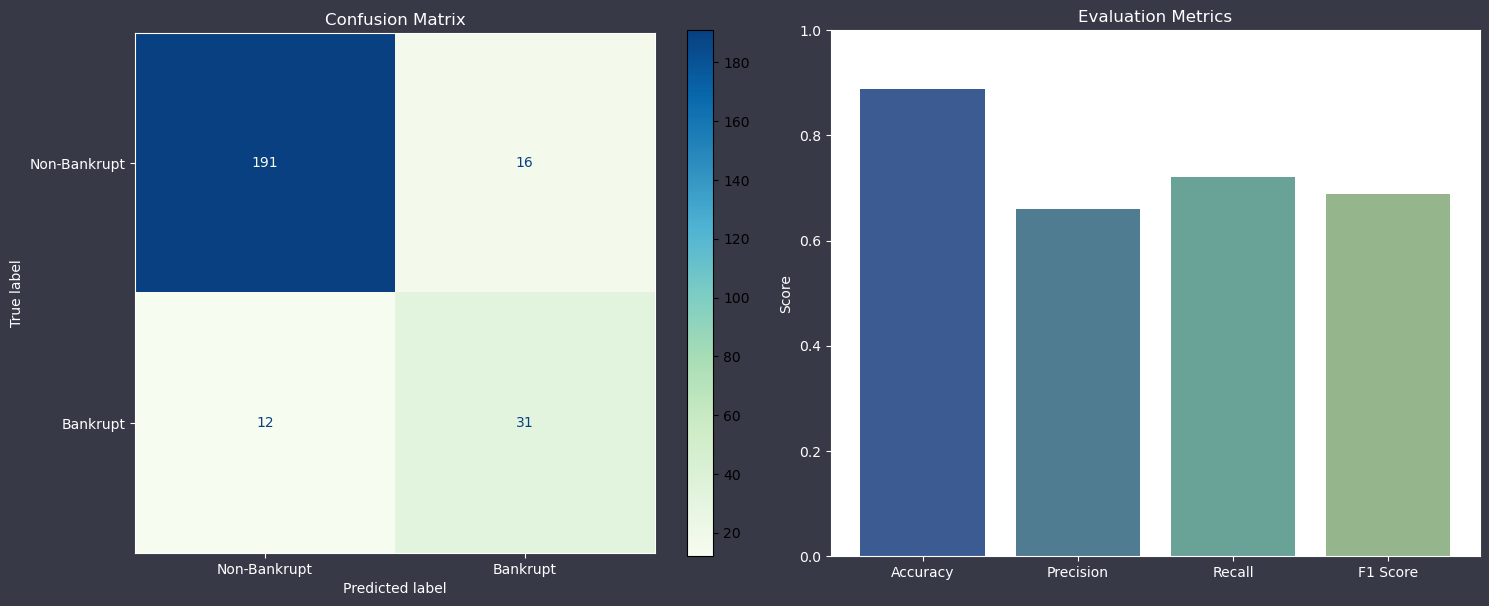

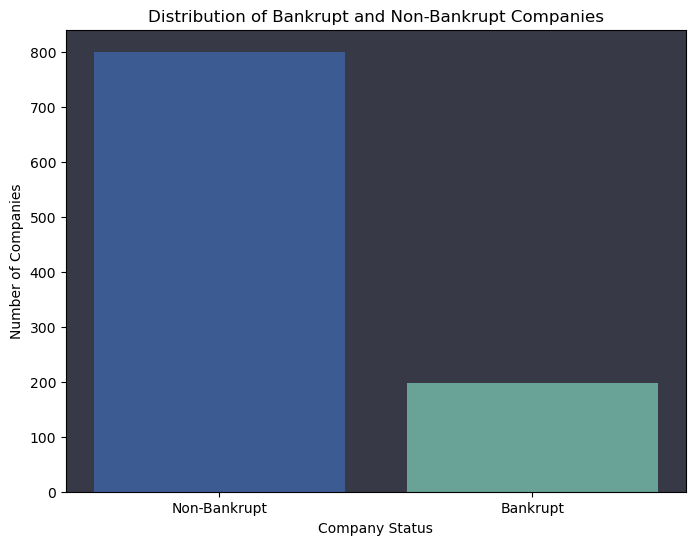

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(800, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

# 특성과 타겟 변수 분리
data_input = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='GnBu')
axes[0].set_title('Confusion Matrix', color='white')
axes[0].set_xlabel('Predicted label', color='white')
axes[0].set_ylabel('True label', color='white')
axes[0].tick_params(colors='white')
for spine in axes[0].spines.values():
    spine.set_edgecolor('white')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
axes[1].bar(metrics, scores, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics', color='white')
axes[1].set_ylabel('Score', color='white')
axes[1].tick_params(colors='white')
for spine in axes[1].spines.values():
    spine.set_edgecolor('white')

plt.tight_layout()
plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#3b5b92', '#69a297'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status', color='white')
plt.ylabel('Number of Companies', color='white')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='white')
plt.gca().set_facecolor('#373947')
plt.gca().tick_params(colors='white')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('white')
plt.show()


파산하지 않는 기업을 파산한다고 예측한다. precision(정밀도)을 높이자
파산할 기업을 파산하지 않는다고 예측한다. recall(재현율)을 높이자

샘플 크기: 200, 훈련 세트 정확도: 0.9194630872483222, 테스트 세트 정확도: 0.91, 교차 검증 평균 정확도: 0.8541139240506329
샘플 크기: 300, 훈련 세트 정확도: 0.8981233243967829, 테스트 세트 정확도: 0.816, 교차 검증 평균 정확도: 0.849191919191919
샘플 크기: 400, 훈련 세트 정확도: 0.9553571428571429, 테스트 세트 정확도: 0.8666666666666667, 교차 검증 평균 정확도: 0.8628151260504202
샘플 크기: 500, 훈련 세트 정확도: 0.9521988527724665, 테스트 세트 정확도: 0.8742857142857143, 교차 검증 평균 정확도: 0.885344295991778
샘플 크기: 600, 훈련 세트 정확도: 0.9531772575250836, 테스트 세트 정확도: 0.92, 교차 검증 평균 정확도: 0.8796462264150943
샘플 크기: 700, 훈련 세트 정확도: 0.937592867756315, 테스트 세트 정확도: 0.8977777777777778, 교차 검증 평균 정확도: 0.8864059590316573
샘플 크기: 800, 훈련 세트 정확도: 0.9545454545454546, 테스트 세트 정확도: 0.884, 교차 검증 평균 정확도: 0.8947989949748744
샘플 크기: 900, 훈련 세트 정확도: 0.9611178614823815, 테스트 세트 정확도: 0.84, 교차 검증 평균 정확도: 0.8934371108343712
샘플 크기: 1000, 훈련 세트 정확도: 0.9599109131403119, 테스트 세트 정확도: 0.87, 교차 검증 평균 정확도: 0.8956450488145048


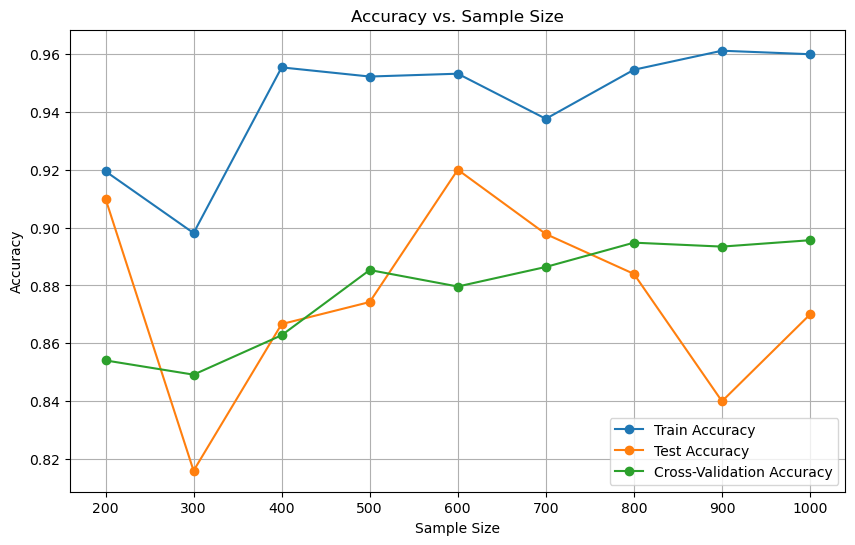

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 데이터 불러오기
data = pd.read_csv('./train_data_reduced.csv')

# 언더샘플링 데이터 개수 설정
sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []

for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [4, 6],
        'bootstrap': [True]
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='accuracy')
    grid_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = grid_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()


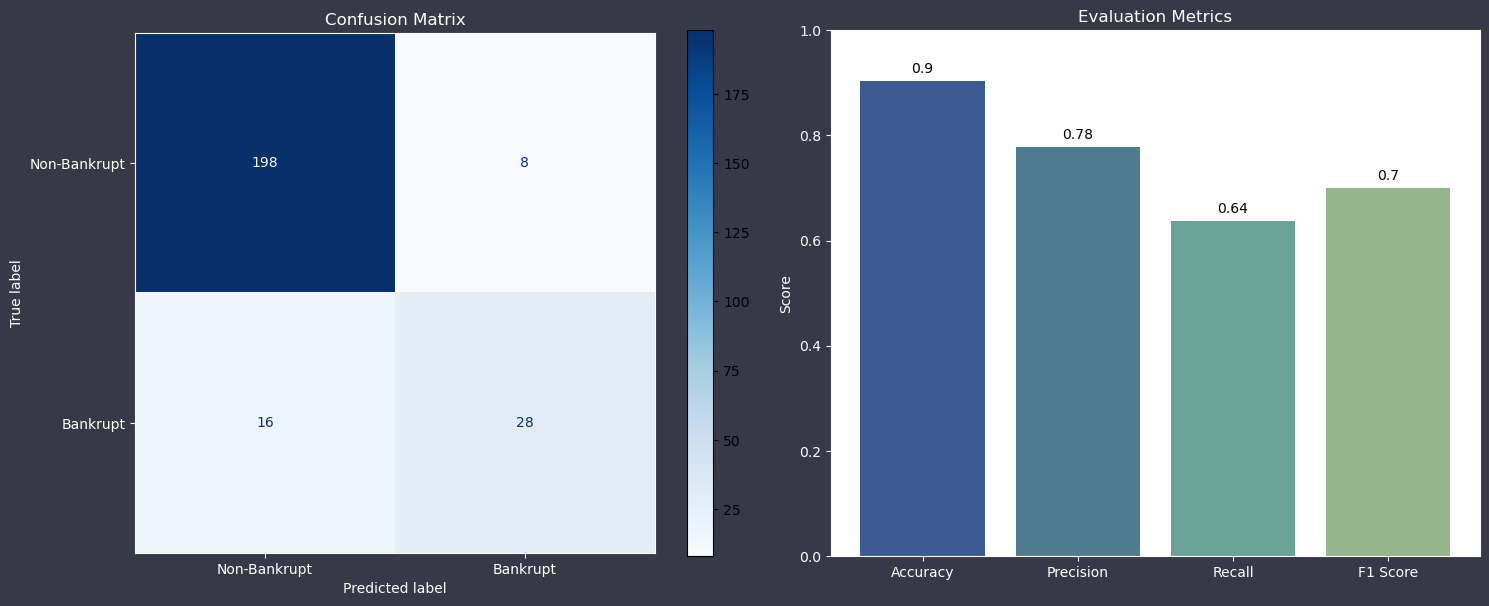

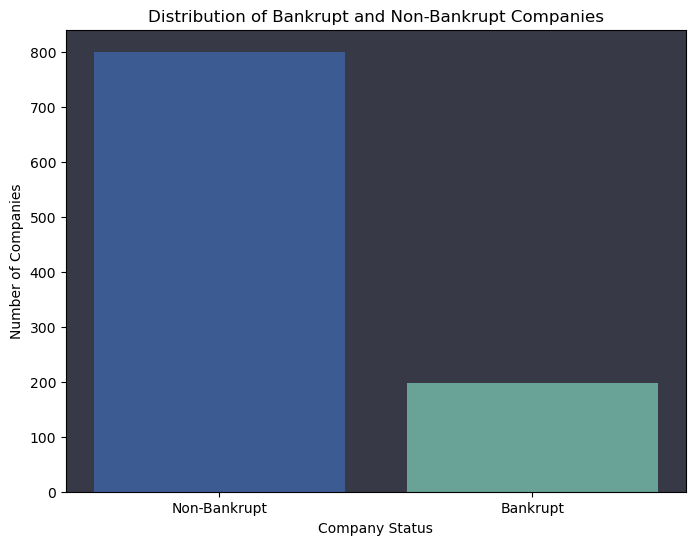

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(800, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

# 특성과 타겟 변수 분리
data_input = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', color='white')
axes[0].set_xlabel('Predicted label', color='white')
axes[0].set_ylabel('True label', color='white')
axes[0].tick_params(colors='white')
for spine in axes[0].spines.values():
    spine.set_edgecolor('white')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
bars = axes[1].bar(metrics, scores, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics', color='white')
axes[1].set_ylabel('Score', color='white')
axes[1].tick_params(colors='white')
for spine in axes[1].spines.values():
    spine.set_edgecolor('white')

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#3b5b92', '#69a297'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status', color='black')
plt.ylabel('Number of Companies', color='black')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='black')
plt.gca().set_facecolor('#373947')
plt.gca().tick_params(colors='black')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.show()


샘플 크기: 200, 훈련 세트 정확도: 0.9295302013422819, 테스트 세트 정확도: 0.83, 교차 검증 평균 정확도: 0.8591455696202532, 재현율: 0.8627450980392157
샘플 크기: 300, 훈련 세트 정확도: 0.9222520107238605, 테스트 세트 정확도: 0.848, 교차 검증 평균 정확도: 0.8433939393939394, 재현율: 0.8113207547169812
샘플 크기: 400, 훈련 세트 정확도: 0.9464285714285714, 테스트 세트 정확도: 0.8666666666666667, 교차 검증 평균 정확도: 0.8495658263305323, 재현율: 0.7407407407407407
샘플 크기: 500, 훈련 세트 정확도: 0.9407265774378585, 테스트 세트 정확도: 0.8571428571428571, 교차 검증 평균 정확도: 0.871120246659815, 재현율: 0.7543859649122807
샘플 크기: 600, 훈련 세트 정확도: 0.9498327759197325, 테스트 세트 정확도: 0.87, 교차 검증 평균 정확도: 0.8822091194968553, 재현율: 0.6825396825396826
샘플 크기: 700, 훈련 세트 정확도: 0.9450222882615156, 테스트 세트 정확도: 0.88, 교차 검증 평균 정확도: 0.8819366852886406, 재현율: 0.7045454545454546
샘플 크기: 800, 훈련 세트 정확도: 0.9425133689839572, 테스트 세트 정확도: 0.868, 교차 검증 평균 정확도: 0.8897638190954773, 재현율: 0.5660377358490566
샘플 크기: 900, 훈련 세트 정확도: 0.9550425273390036, 테스트 세트 정확도: 0.9054545454545454, 교차 검증 평균 정확도: 0.8961643835616439, 재현율: 0.6666666666666666
샘플 크기

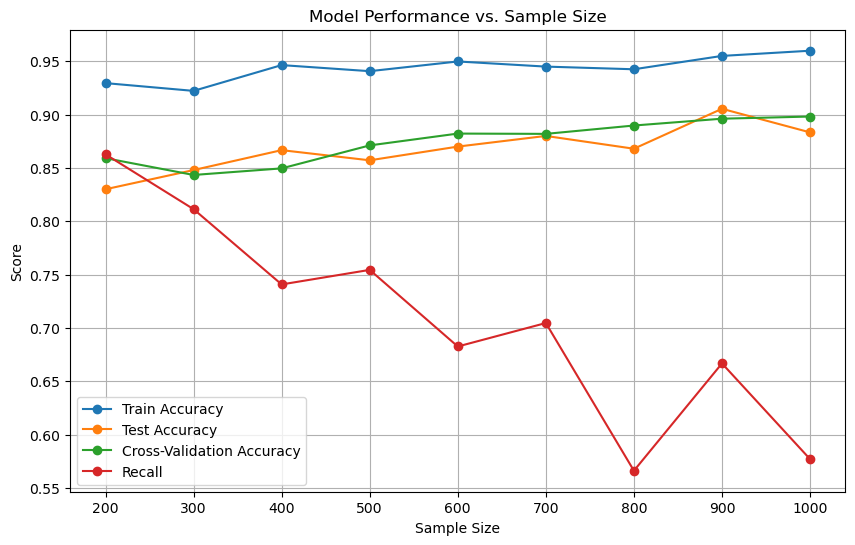

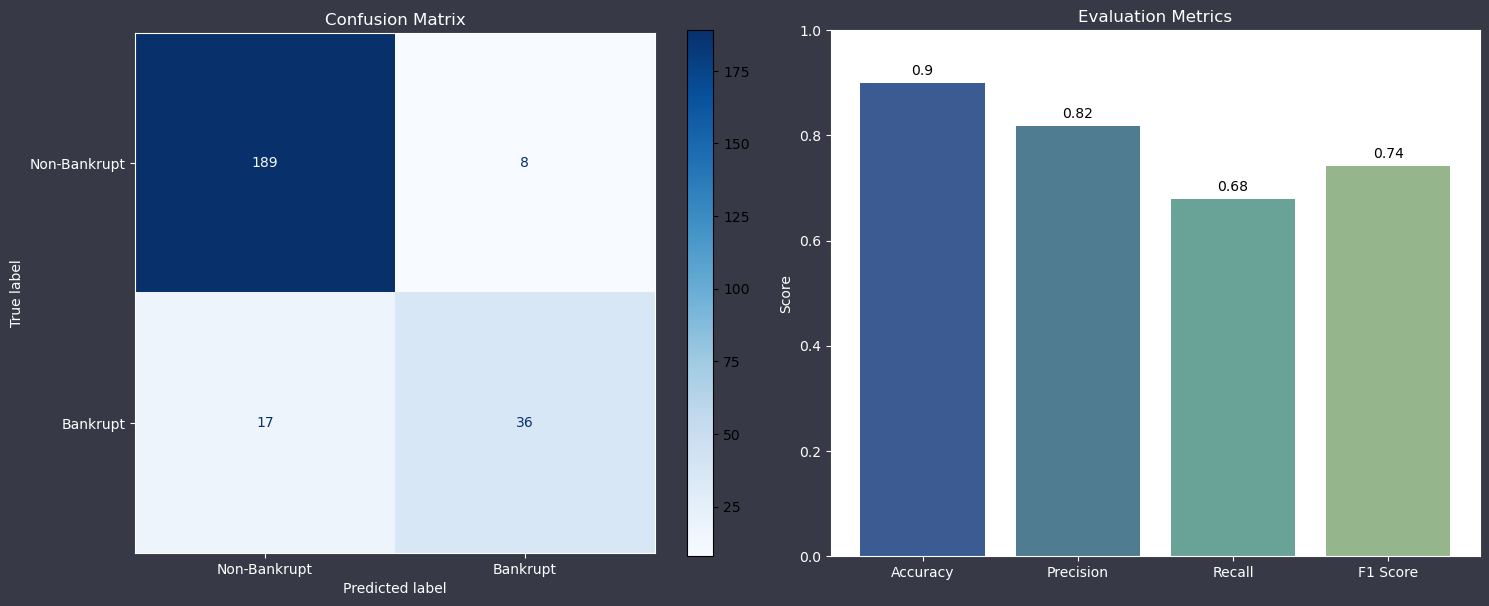

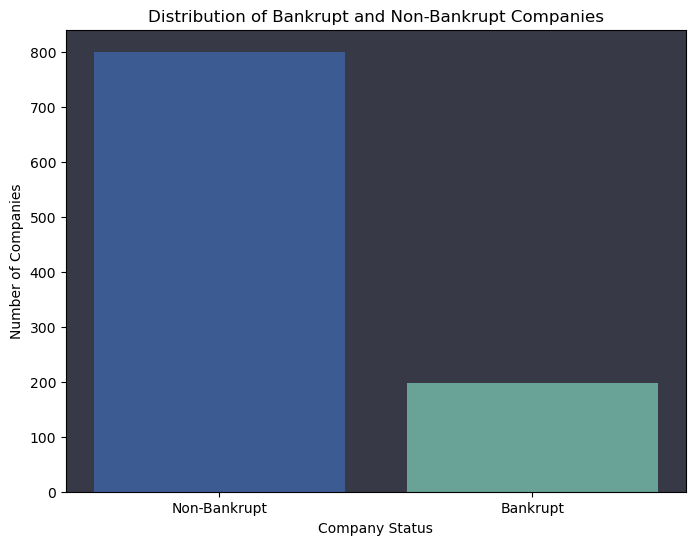

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 데이터 불러오기
data = pd.read_csv('./train_data_reduced.csv')

# 언더샘플링 데이터 개수 설정
sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [4, 6],
        'bootstrap': [True]
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='accuracy')
    grid_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = grid_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()

# 추가 코드: 단일 샘플 크기에서의 평가 지표 시각화

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(800, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

# 특성과 타겟 변수 분리
data_input = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', color='white')
axes[0].set_xlabel('Predicted label', color='white')
axes[0].set_ylabel('True label', color='white')
axes[0].tick_params(colors='white')
for spine in axes[0].spines.values():
    spine.set_edgecolor('white')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
bars = axes[1].bar(metrics, scores, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics', color='white')
axes[1].set_ylabel('Score', color='white')
axes[1].tick_params(colors='white')
for spine in axes[1].spines.values():
    spine.set_edgecolor('white')

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#3b5b92', '#69a297'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status', color='black')
plt.ylabel('Number of Companies', color='black')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='black')
plt.gca().set_facecolor('#373947')
plt.gca().tick_params(colors='black')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.show()


샘플 크기: 200, 훈련 세트 정확도: 0.9731543624161074, 테스트 세트 정확도: 0.82, 교차 검증 평균 정확도: 0.8543037974683545, 재현율: 0.8723404255319149
샘플 크기: 300, 훈련 세트 정확도: 0.9517426273458445, 테스트 세트 정확도: 0.888, 교차 검증 평균 정확도: 0.8594545454545454, 재현율: 0.8979591836734694
샘플 크기: 400, 훈련 세트 정확도: 0.9375, 테스트 세트 정확도: 0.8466666666666667, 교차 검증 평균 정확도: 0.8578851540616247, 재현율: 0.8181818181818182
샘플 크기: 500, 훈련 세트 정확도: 0.9770554493307839, 테스트 세트 정확도: 0.8628571428571429, 교차 검증 평균 정확도: 0.8581603288797535, 재현율: 0.7962962962962963
샘플 크기: 600, 훈련 세트 정확도: 0.9297658862876255, 테스트 세트 정확도: 0.89, 교차 검증 평균 정확도: 0.8696383647798743, 재현율: 0.7547169811320755
샘플 크기: 700, 훈련 세트 정확도: 0.9524517087667161, 테스트 세트 정확도: 0.8977777777777778, 교차 검증 평균 정확도: 0.8775108628181254, 재현율: 0.7333333333333333
샘플 크기: 800, 훈련 세트 정확도: 0.9505347593582888, 테스트 세트 정확도: 0.904, 교차 검증 평균 정확도: 0.894748743718593, 재현율: 0.7209302325581395
샘플 크기: 900, 훈련 세트 정확도: 0.9538274605103281, 테스트 세트 정확도: 0.8836363636363637, 교차 검증 평균 정확도: 0.8879659609796595, 재현율: 0.6818181818181818
샘플 

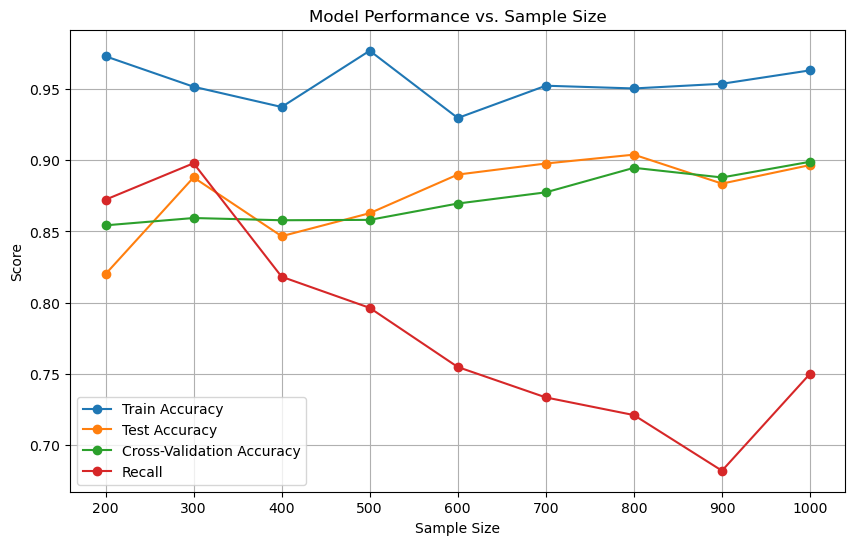

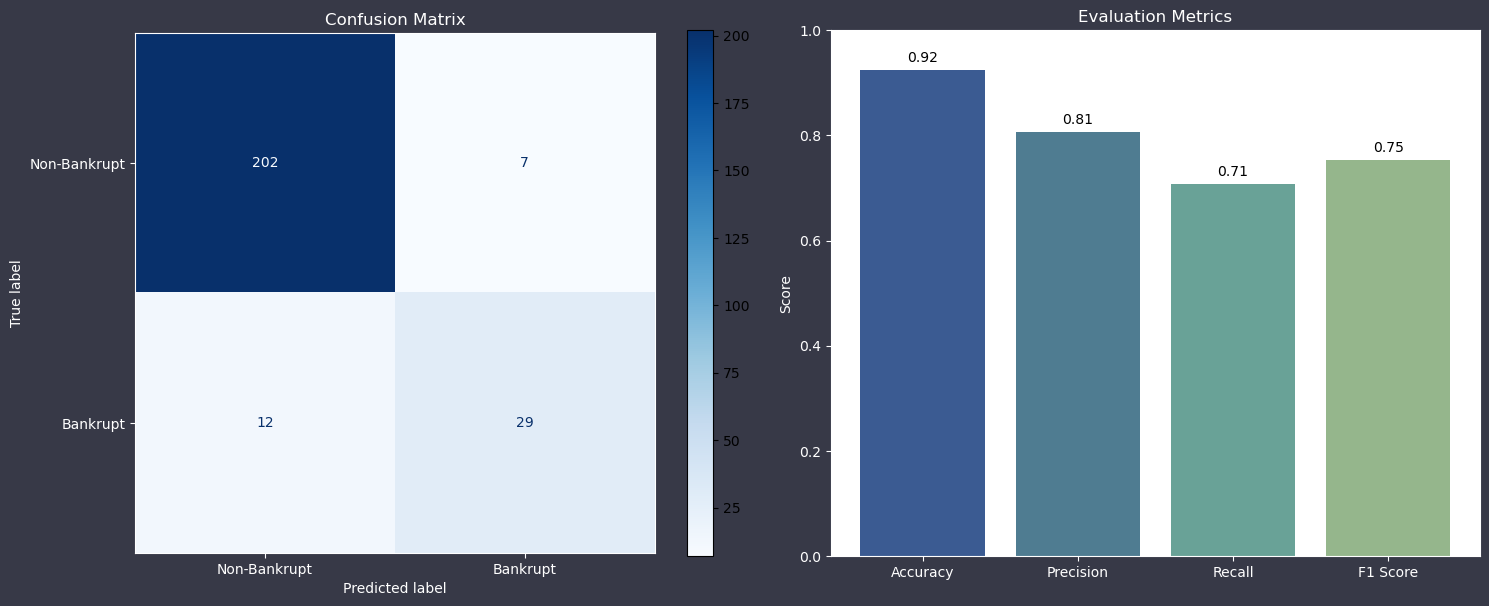

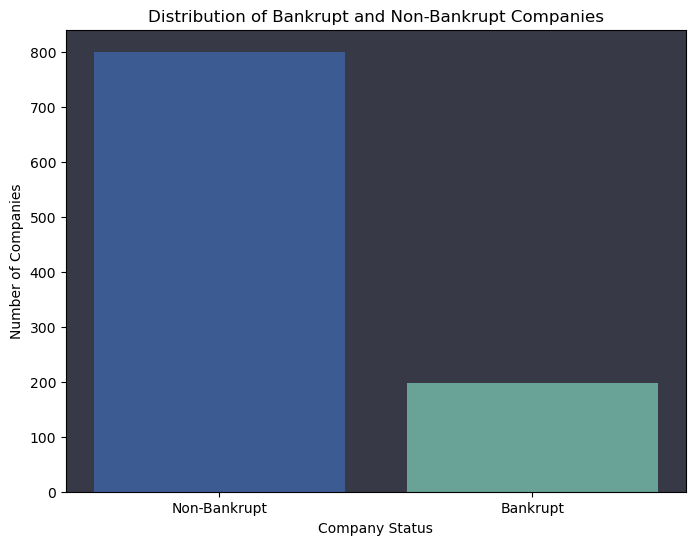

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy.stats import randint

# 데이터 불러오기
data = pd.read_csv('./train_data_reduced.csv')

# 언더샘플링 데이터 개수 설정
sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)

    # 하이퍼파라미터 튜닝 (랜덤 서치)
    param_dist = {
        'n_estimators': randint(100, 200),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(10, 20),
        'min_samples_leaf': randint(4, 10),
        'bootstrap': [True, False]
    }

    random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=50,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='accuracy',
                                       random_state=42)
    random_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = random_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()

# 추가 코드: 단일 샘플 크기에서의 평가 지표 시각화

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(800, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

# 특성과 타겟 변수 분리
data_input = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', color='white')
axes[0].set_xlabel('Predicted label', color='white')
axes[0].set_ylabel('True label', color='white')
axes[0].tick_params(colors='white')
for spine in axes[0].spines.values():
    spine.set_edgecolor('white')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
bars = axes[1].bar(metrics, scores, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics', color='white')
axes[1].set_ylabel('Score', color='white')
axes[1].tick_params(colors='white')
for spine in axes[1].spines.values():
    spine.set_edgecolor('white')

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#3b5b92', '#69a297'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status', color='black')
plt.ylabel('Number of Companies', color='black')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='black')
plt.gca().set_facecolor('#373947')
plt.gca().tick_params(colors='black')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.show()


In [6]:
#1차 데이터 전처리 특성중요도 0.01미만 54개 제거
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 데이터 불러오기
data = pd.read_csv('./data.csv')

# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)

# 특성 중요도 확인
importances = rf_model.feature_importances_
features = data_input.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 중요도가 낮은 특성 제거 (중요도 0.01 미만인 특성 제거)
important_features = feature_importances[feature_importances['Importance'] > 0.01]['Feature']
data_input_reduced = data_input[important_features]

# 중요한 특성만 포함한 데이터프레임에 타겟 변수 'Bankrupt?' 컬럼 추가
data_reduced_with_target = data_input_reduced.copy()
data_reduced_with_target['Bankrupt?'] = data_target


data_reduced_with_target.to_csv('./data_reduced.csv', index=False)



샘플 크기: 200, 훈련 세트 정확도: 0.9301587301587302, 테스트 세트 정확도: 0.8761904761904762, 교차 검증 평균 정확도: 0.8880952380952382, 재현율: 0.8928571428571429
샘플 크기: 300, 훈련 세트 정확도: 0.9358974358974359, 테스트 세트 정확도: 0.8461538461538461, 교차 검증 평균 정확도: 0.8865384615384615, 재현율: 0.8181818181818182
샘플 크기: 400, 훈련 세트 정확도: 0.9333333333333333, 테스트 세트 정확도: 0.8774193548387097, 교차 검증 평균 정확도: 0.882258064516129, 재현율: 0.8771929824561403
샘플 크기: 500, 훈련 세트 정확도: 0.9462962962962963, 테스트 세트 정확도: 0.8777777777777778, 교차 검증 평균 정확도: 0.8847222222222222, 재현율: 0.828125
샘플 크기: 600, 훈련 세트 정확도: 0.9447154471544715, 테스트 세트 정확도: 0.8780487804878049, 교차 검증 평균 정확도: 0.8865853658536584, 재현율: 0.7307692307692307
샘플 크기: 700, 훈련 세트 정확도: 0.9594202898550724, 테스트 세트 정확도: 0.8913043478260869, 교차 검증 평균 정확도: 0.8945652173913043, 재현율: 0.75
샘플 크기: 800, 훈련 세트 정확도: 0.9464052287581699, 테스트 세트 정확도: 0.8862745098039215, 교차 검증 평균 정확도: 0.8970588235294118, 재현율: 0.62
샘플 크기: 900, 훈련 세트 정확도: 0.9595238095238096, 테스트 세트 정확도: 0.9107142857142857, 교차 검증 평균 정확도: 0.9, 재현율: 0.64
샘플 크

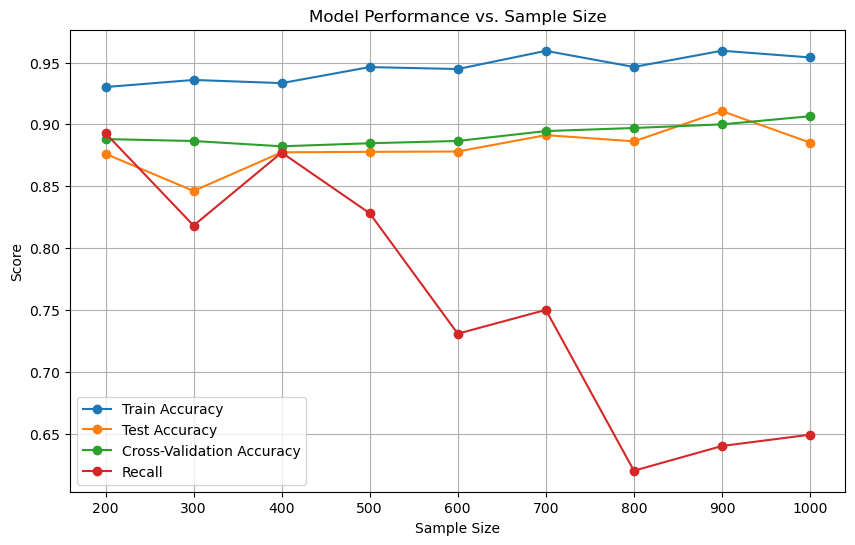

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


data = pd.read_csv('./data_reduced.csv')

sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [4, 6],
        'bootstrap': [True]
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='accuracy')
    grid_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = grid_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()

샘플 크기: 200, 훈련 세트 정확도: 0.9365079365079365, 테스트 세트 정확도: 0.8952380952380953, 교차 검증 평균 정확도: 0.880952380952381, 재현율: 0.8813559322033898
샘플 크기: 300, 훈련 세트 정확도: 0.9512820512820512, 테스트 세트 정확도: 0.9153846153846154, 교차 검증 평균 정확도: 0.8903846153846153, 재현율: 0.9148936170212766
샘플 크기: 400, 훈련 세트 정확도: 0.9354838709677419, 테스트 세트 정확도: 0.8838709677419355, 교차 검증 평균 정확도: 0.8870967741935484, 재현율: 0.8688524590163934
샘플 크기: 500, 훈련 세트 정확도: 0.9296296296296296, 테스트 세트 정확도: 0.9, 교차 검증 평균 정확도: 0.8875, 재현율: 0.8275862068965517
샘플 크기: 600, 훈련 세트 정확도: 0.9365853658536586, 테스트 세트 정확도: 0.8780487804878049, 교차 검증 평균 정확도: 0.8878048780487806, 재현율: 0.7454545454545455
샘플 크기: 700, 훈련 세트 정확도: 0.9376811594202898, 테스트 세트 정확도: 0.8782608695652174, 교차 검증 평균 정확도: 0.8891304347826086, 재현율: 0.7209302325581395
샘플 크기: 800, 훈련 세트 정확도: 0.9516339869281045, 테스트 세트 정확도: 0.8941176470588236, 교차 검증 평균 정확도: 0.8980392156862745, 재현율: 0.6530612244897959
샘플 크기: 900, 훈련 세트 정확도: 0.955952380952381, 테스트 세트 정확도: 0.8964285714285715, 교차 검증 평균 정확도: 0.9017857

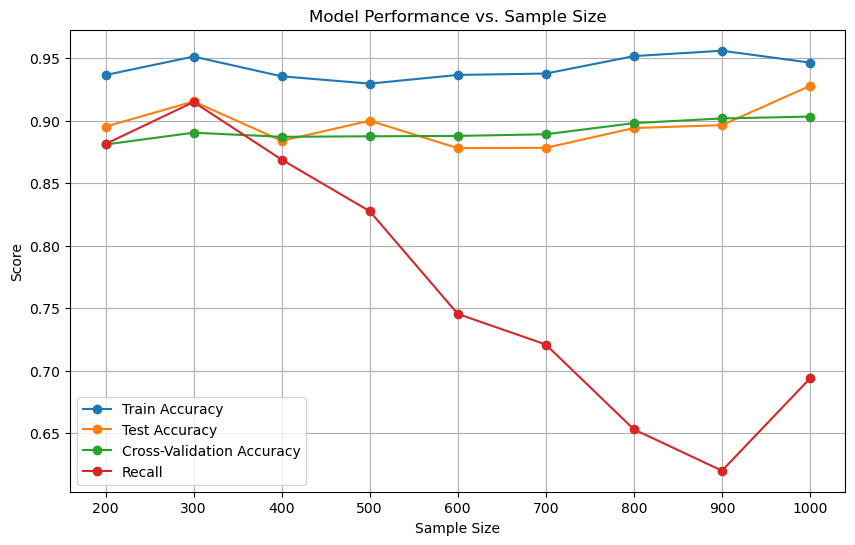

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv('./data_reduced.csv')

sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

# 고정된 random_state를 사용하여 데이터 샘플링 유지
for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [4, 6],
        'bootstrap': [True]
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='accuracy')
    grid_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = grid_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()


샘플 크기: 200, 훈련 세트 정확도: 0.9238095238095239, 테스트 세트 정확도: 0.8857142857142857, 교차 검증 평균 정확도: 0.8785714285714287, 재현율: 0.864406779661017
샘플 크기: 300, 훈련 세트 정확도: 0.9384615384615385, 테스트 세트 정확도: 0.9230769230769231, 교차 검증 평균 정확도: 0.8884615384615385, 재현율: 0.9148936170212766
샘플 크기: 400, 훈련 세트 정확도: 0.9806451612903225, 테스트 세트 정확도: 0.8774193548387097, 교차 검증 평균 정확도: 0.8870967741935484, 재현율: 0.8524590163934426
샘플 크기: 500, 훈련 세트 정확도: 0.9685185185185186, 테스트 세트 정확도: 0.8888888888888888, 교차 검증 평균 정확도: 0.8833333333333332, 재현율: 0.7931034482758621
샘플 크기: 600, 훈련 세트 정확도: 0.9479674796747968, 테스트 세트 정확도: 0.8731707317073171, 교차 검증 평균 정확도: 0.8914634146341462, 재현율: 0.7454545454545455
샘플 크기: 700, 훈련 세트 정확도: 0.9318840579710145, 테스트 세트 정확도: 0.8782608695652174, 교차 검증 평균 정확도: 0.8869565217391304, 재현율: 0.6976744186046512
샘플 크기: 800, 훈련 세트 정확도: 0.9856209150326798, 테스트 세트 정확도: 0.8901960784313725, 교차 검증 평균 정확도: 0.9058823529411765, 재현율: 0.6530612244897959
샘플 크기: 900, 훈련 세트 정확도: 0.975, 테스트 세트 정확도: 0.8964285714285715, 교차 검증 평균

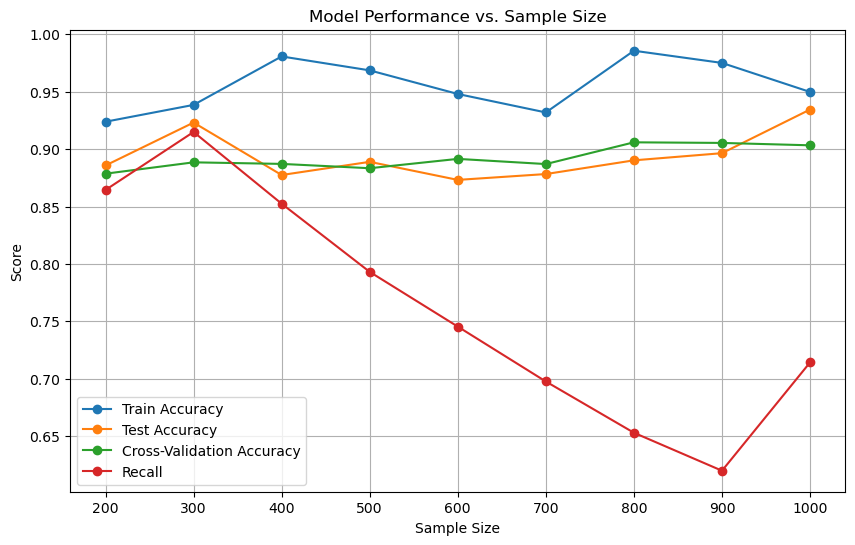

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from scipy.stats import randint

# 데이터 불러오기
data = pd.read_csv('./data_reduced.csv')

sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

# 고정된 random_state를 사용하여 데이터 샘플링 유지
for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝 (랜덤 서치)
    param_dist = {
        'n_estimators': randint(100, 200),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(10, 20),
        'min_samples_leaf': randint(4, 10),
        'bootstrap': [True, False]
    }

    random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=100,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='accuracy',
                                       random_state=42)
    random_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = random_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()


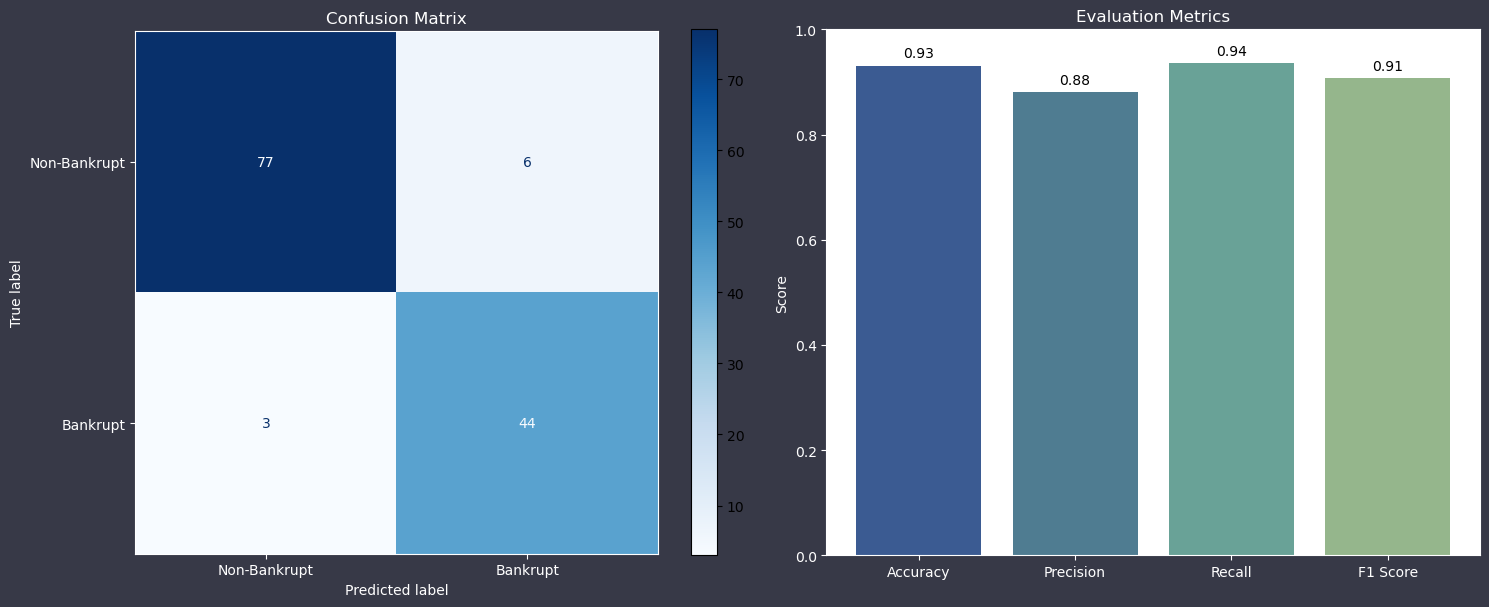

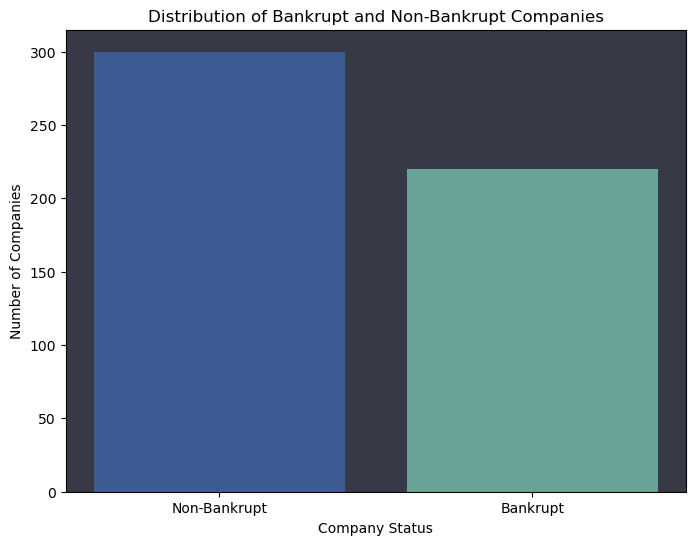

In [17]:
# 데이터 불러오기
data = pd.read_csv('./data.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(300, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

# 특성과 타겟 변수 분리
data_input = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', color='white')
axes[0].set_xlabel('Predicted label', color='white')
axes[0].set_ylabel('True label', color='white')
axes[0].tick_params(colors='white')
for spine in axes[0].spines.values():
    spine.set_edgecolor('white')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
bars = axes[1].bar(metrics, scores, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics', color='white')
axes[1].set_ylabel('Score', color='white')
axes[1].tick_params(colors='white')
for spine in axes[1].spines.values():
    spine.set_edgecolor('white')

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['#3b5b92', '#69a297'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status', color='black')
plt.ylabel('Number of Companies', color='black')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='black')
plt.gca().set_facecolor('#373947')
plt.gca().tick_params(colors='black')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.show()